In [46]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.utils import shuffle


In [47]:
# Define the mean vectors and covariance matrix
mean_1 = np.array([0, 2])
cov_1 = 0.5 * np.eye(2)

mean_2 = np.array([0, -2])
cov_2 = 0.5 * np.eye(2)

means = [mean_1, mean_2]
covs = [cov_1, cov_2]
probabilites = [0.5, 0.5]
num_clusters = len(means)

# Initialize an empty list to store the samples
data = []
clusters = []

num_samples = 1000
for _ in range(num_samples):
    cluster = np.random.choice(range(num_clusters), p=probabilites)
    sample = np.random.multivariate_normal(means[cluster], covs[cluster])
    
    data.append(sample)
    clusters.append(cluster)

# Convert the list to a NumPy array for easier handling
data = np.array(data)

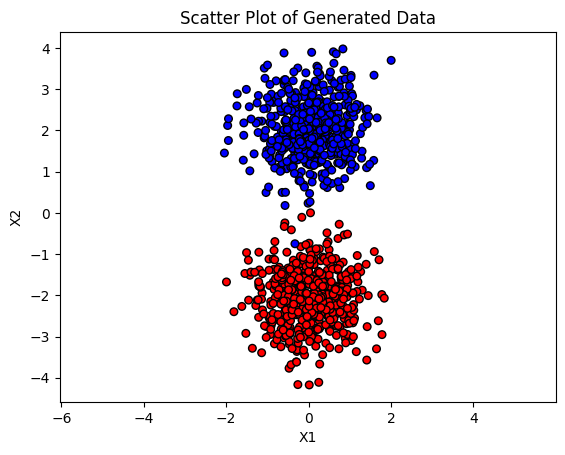

In [48]:
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='bwr', s=30, edgecolors='k')
plt.title('Scatter Plot of Generated Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.show()

In [49]:
# X: feature matrix, y: true cluster labels (ground truth)
X_train, X_test, y_train, y_test = train_test_split(data, clusters, test_size=0.2, random_state=42)

In [50]:
# Use k-means to cluster the data on the training set
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_train)

# Assign clusters to the training set
train_clusters = kmeans.labels_

# One-hot encode the cluster assignments
encoder = OneHotEncoder(sparse=False)
train_clusters_encoded = encoder.fit_transform(train_clusters.reshape(-1, 1))

In [51]:
# Train a Random Forest model using the features and the cluster assignments as targets
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, train_clusters_encoded)

RandomForestClassifier(random_state=42)

In [52]:
def evaluate_model(X, y, model):
    cluster_proba = model.predict_proba(X)
    predicted_clusters = np.argmax(np.hstack(cluster_proba), axis=1)

    ari = adjusted_rand_score(y, predicted_clusters)
    acc = accuracy_score(y, predicted_clusters)

    return ari, acc   

train_ari, train_acc = evaluate_model(X_train, y_train, rf_model)
print(f"Adjusted Rand Index on training set (no permutation): {train_ari}")
print(f"Accuracy on training set (no permutation): {train_acc}")

test_ari, test_acc = evaluate_model(X_test, y_test, rf_model)
print(f"Adjusted Rand Index on test set (no permutation): {test_ari}")
print(f"Accuracy on test set (no permutation): {test_acc}")

Adjusted Rand Index on training set (no permutation): 0.9900125013763318
Accuracy on training set (no permutation): 0.9975
Adjusted Rand Index on test set (no permutation): 0.9799992828206764
Accuracy on test set (no permutation): 0.995


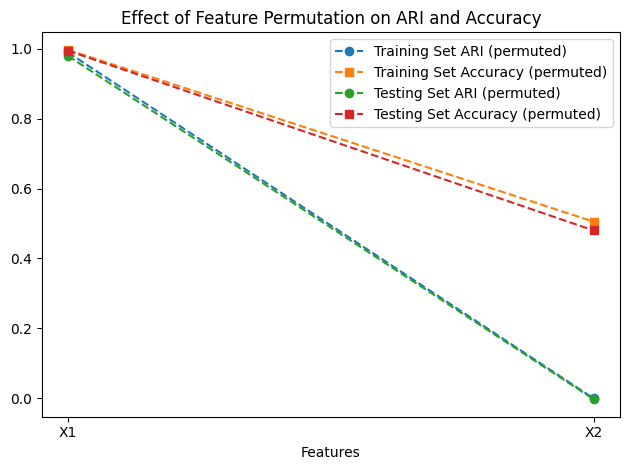

In [53]:
# Now we will permute each feature one at a time, for both the training and testing sets
n_features = X_train.shape[1]
shuffle_train_ari = np.empty((n_features))
shuffle_train_acc = np.empty((n_features))

shuffle_test_ari = np.empty((n_features))
shuffle_test_acc = np.empty((n_features))

for i in range(n_features):
    # Permute the i-th feature in the training data
    X_train_permuted = X_train.copy()
    X_train_permuted[:, i] = shuffle(X_train_permuted[:, i], random_state=42)
    
    # Permute the i-th feature in the testing data
    X_test_permuted = X_test.copy()
    X_test_permuted[:, i] = shuffle(X_test_permuted[:, i], random_state=42)

    # Store the resulting ARI and accuracy metrics
    shuffle_train_ari[i], shuffle_train_acc[i] = evaluate_model(X_train_permuted, y_train, rf_model)
    shuffle_test_ari[i], shuffle_test_acc[i] = evaluate_model(X_test_permuted, y_test, rf_model)

# Plot the results
features = [f'X{i+1}' for i in range(n_features)]
plt.plot(features, shuffle_train_ari, label='Training Set ARI (permuted)', marker='o', linestyle='--')
plt.plot(features, shuffle_train_acc, label='Training Set Accuracy (permuted)', marker='s', linestyle='--')
plt.plot(features, shuffle_test_ari, label='Testing Set ARI (permuted)', marker='o', linestyle='--')
plt.plot(features, shuffle_test_acc, label='Testing Set Accuracy (permuted)', marker='s', linestyle='--')
plt.xlabel('Features')
plt.title('Effect of Feature Permutation on ARI and Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Now, what if `X1` and `X2` are both equally important?

In [54]:
means_2 = [
    np.array([2, 2]),
    np.array([-2, 2]),
    np.array([2, -2]),
    np.array([-2, -2])
]

covs_2 = [
    0.5 * np.eye(2),
    0.5 * np.eye(2),
    0.5 * np.eye(2),
    0.5 * np.eye(2)
]

probabilities_2 = [0.25, 0.25, 0.25, 0.25]

def generate_data(means, covs, probs, num_samples):
    assert(len(means) == len(covs) == len(probs))

    data = []
    clusters = []

    num_clusters = len(means)
    num_samples = 1000
    for _ in range(num_samples):
        cluster = np.random.choice(range(num_clusters), p=probs)
        sample = np.random.multivariate_normal(means[cluster], covs[cluster])
        
        data.append(sample)
        clusters.append(cluster)

    return np.array(data), clusters

data_2, clusters_2 = generate_data(means_2, covs_2, probabilities_2, 10000)

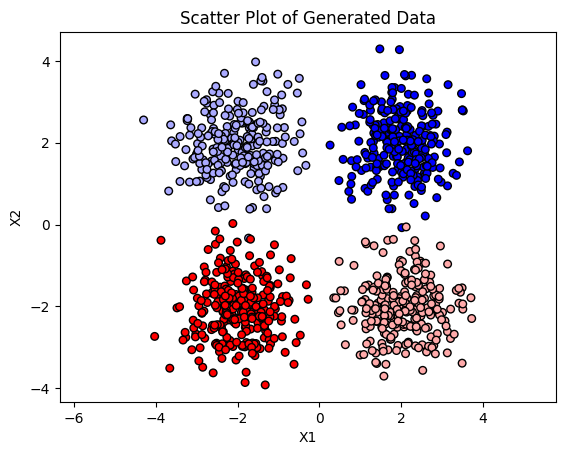

In [55]:
plt.scatter(data_2[:, 0], data_2[:, 1], c=clusters_2, cmap='bwr', s=30, edgecolors='k')
plt.title('Scatter Plot of Generated Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.axis('equal')
plt.show()

In [56]:
def get_feature_importance(data, clusters, test_size=0.2):
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, clusters, test_size=test_size)

    # Use k-means to assign clusters
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train)

    # Assign clusters to the training set
    train_clusters = kmeans.labels_

    # One-hot encode the cluster assignments
    encoder = OneHotEncoder(sparse=False)
    train_clusters_encoded = encoder.fit_transform(train_clusters.reshape(-1, 1))

    # Train a Random Forest model using the features and the cluster assignments as targets
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, train_clusters_encoded)

    # Now we will permute each feature one at a time, for both the training and testing sets
    n_features = X_train.shape[1]
    shuffle_train_ari = np.empty((n_features))
    shuffle_train_acc = np.empty((n_features))

    shuffle_test_ari = np.empty((n_features))
    shuffle_test_acc = np.empty((n_features))

    for i in range(n_features):
        # Permute the i-th feature in the training data
        X_train_permuted = X_train.copy()
        X_train_permuted[:, i] = shuffle(X_train_permuted[:, i], random_state=42)
        
        # Permute the i-th feature in the testing data
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i], random_state=42)

        # Store the resulting ARI and accuracy metrics
        shuffle_train_ari[i], shuffle_train_acc[i] = evaluate_model(X_train_permuted, y_train, rf_model)
        shuffle_test_ari[i], shuffle_test_acc[i] = evaluate_model(X_test_permuted, y_test, rf_model)

    return {
        "Shuffle train ARI" : shuffle_train_ari,
        "Shuffle train accuracy" : shuffle_train_acc,
        "Shuffle test ARI" : shuffle_test_ari,
        "Shuffle test accuracy" : shuffle_test_acc
    }

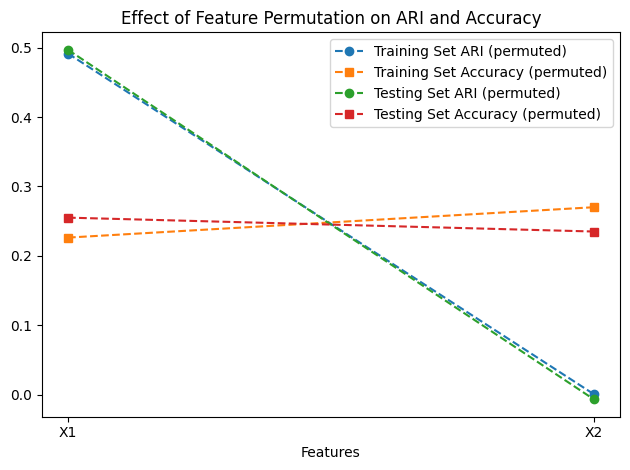

In [61]:
results_2 = get_feature_importance(data_2, clusters_2)

# Plot the results
features = [f'X{i+1}' for i in range(n_features)]
plt.plot(features, results_2["Shuffle train ARI"], label='Training Set ARI (permuted)', marker='o', linestyle='--')
plt.plot(features, results_2["Shuffle train accuracy"], label='Training Set Accuracy (permuted)', marker='s', linestyle='--')
plt.plot(features, results_2["Shuffle test ARI"], label='Testing Set ARI (permuted)', marker='o', linestyle='--')
plt.plot(features, results_2["Shuffle test accuracy"], label='Testing Set Accuracy (permuted)', marker='s', linestyle='--')
plt.xlabel('Features')
plt.title('Effect of Feature Permutation on ARI and Accuracy')
plt.legend()
plt.tight_layout()
plt.show()